In [ ]:
# !pip install scipy
# !pip install statsmodels

In [338]:
#from google.colab import files
import pandas as pd
import numpy as np
import calendar
# import warnings
from scipy.stats import spearmanr, kendalltau
from scipy.stats import entropy
import seaborn as sns

import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Cargando rutas de archivos y funciones

In [339]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'
# --
ruta_perdida_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_otros_full_group.csv'




In [340]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))



## FUNCION COMPLETITUD PENALIZADA
## #######################
## #######################
## #######################

def function_completitud_pen(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')
    df_merged['FECHA'] = pd.to_datetime(df_merged['FECHA'])
    dim_start = df_merged.shape[0]

    # Filtrar filas donde el día de la semana no sea domingo (domingo es 6)
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 6]
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 5]

    dim_finish = df_merged.shape[0]

    dim_reduccion = dim_finish/dim_start

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    sum_variable_con_datos = df_merged['variable_con_datos'].sum()
    sum_variable_sin_datos = df_merged['variable_sin_datos'].sum()
    pctj_completitud_total = sum_variable_con_datos/(sum_variable_con_datos + sum_variable_sin_datos)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Sin considerar dias sábados/domingos: {dim_reduccion}')
    print(f'Dataframe creados: df_year, df_month')
    print(f'pctj_completitud_total= {pctj_completitud_total}')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))






## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    # Si solo te interesa modificar el primer valor (o un único valor) puedes hacer:
    if 'Shanuzi' in plantacion_name:
        plantacion_name = ['Shanuzi']
    else:
        plantacion_name = plantacion_name.tolist()
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Pesos')
    # plt.title(f'{plantacion_name[0]}: variable {valor} - a través del Tiempo ')
    plt.title(f'variable {valor} - a través del Tiempo ')
   
    plt.xlabel('Fecha')
    plt.ylabel('Pesos')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()




## FUNCION CORRELACION CRUZADA
## #######################
## #######################
## #######################

def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr





## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



### Cargando datos processed

In [341]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full)
df_perdida_aceite_full['FECHA'] = pd.to_datetime(df_perdida_aceite_full['FECHA'])

# --
df_perdida_cosecha_full_vf = pd.read_csv(ruta_path + ruta_perdida_cosecha)


### Visualizando datos/ completitud de datos

In [ ]:
# df_sabana_fabrica_full.head(15)
# df_sabana_balanza_full.head()       # --> se actualizará con la data de Rolly (CashCost)

# df_sabana_saldo_campo_full_vf.head()

# print(df_calidad_precipitacion_full.dtypes)
# df_calidad_precipitacion_full.head()

# df_calidad_racimos_propios_full.head()
# df_calidad_antiguedad_frutos_full.head()

# df_acidez_full.head()
df_perdida_aceite_full.head()


In [ ]:
df_sabana_fabrica_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'MES_NRO':'count'})

In [ ]:
df_sabana_balanza_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PTANIO':'count'})

In [ ]:
df_sabana_saldo_campo_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                        'SALDO':'count'})

In [ ]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                         'PLANTACION':'count'})

In [ ]:
df_calidad_racimos_propios_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_sabana_calidad_terceros_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                           'PLANTACION':'count'})

In [ ]:
df_calidad_antiguedad_frutos_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                             'PLANTACION':'count'})

In [ ]:
df_acidez_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                          'PLANTACION':'count'})

In [ ]:
df_clima_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                            'PLANTACION':'count'})

In [ ]:
df_freq_cosecha_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                'PLANTACION':'count'})

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                          'PLANTACION':'count'})

In [ ]:
df_perdida_aceite_full.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                  'PLANTACION':'count'})

In [ ]:
df_perdida_cosecha_full_vf.groupby('PLANTACION').agg({'FECHA':['min','max'],
                                                      'PLANTACION':'count'})

##### --------------------------------------------

In [ ]:
df_clima_full_vf.head()
#df_participacion_cashcost_full.dtypes

In [ ]:
df_clima_full_vf.groupby('PLANTACION').size()

In [ ]:
function_completitud_pen(df_clima_full_vf[df_clima_full_vf['PLANTACION'] == 'Nuevo Horizonte'],'Temp Hi',1)

In [ ]:
# df_sabana_fabrica_full.groupby('PLANTACION').size()
# df_sabana_balanza_full.groupby('PLANTACION').size()
# df_sabana_saldo_campo_full_vf.groupby('PLANTACION').size()
# df_calidad_precipitacion_full.groupby('PLANTACION').size()


##### Transformando datos

In [ ]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS','TERCEROS','TOTAL','PARTICIPACION CP']], 
                       df_sabana_fabrica_full[['FECHA','PLANTACION','RFF PROCESADO','CPO OBTENIDO','TEA']], 
                       on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])


print(f'df_sabana_balanza_full: {df_sabana_balanza_full.shape}')
print(f'df_sabana_fabrica_full: {df_sabana_fabrica_full.shape}')

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_calidad_precipitacion_full, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head(15)

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Palmawasi'], 'TERCEROS')

In [ ]:
# AÑADIENDO DATOS DE CALIDAD RACIMOS PROPIOS
# #######################
# #######################

df_calidad_racimos_propios_full.tail()
# df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'].tail(15)


In [ ]:
df_calidad_racimos_propios_full_group = df_calidad_racimos_propios_full.groupby(['FECHA','PLANTACION','SECTOR']).agg({'VERDES':'sum',
                                                                                                                      'MADUROS':'sum',
                                                                                                                      'SMADUROS':'sum',
                                                                                                                      'PEDUNCULO':'sum',
                                                                                                                      'ESCOBAJO':'sum',
                                                                                                                      'MALFORMADOA':'sum',
                                                                                                                      'MALFORMADOB': 'sum',
                                                                                                                      'Peso':'sum',
                                                                                                                      'Racimos':'sum'}).reset_index()

# Validamos presencia de duplicados en la bbdd
df_prueba = df_calidad_racimos_propios_full[['FECHA','PLANTACION','SECTOR']].drop_duplicates()
print(df_calidad_racimos_propios_full.shape)
print(df_prueba.shape)

# Creando variables de calidad
df_calidad_racimos_propios_full_group['Peso_CALIDAD'] = df_calidad_racimos_propios_full_group[['VERDES','MADUROS','SMADUROS','PEDUNCULO','ESCOBAJO']].sum(axis=1)

df_calidad_racimos_propios_full_group['Peso_VERDES'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['VERDES']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_MADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['MADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_SMADUROS'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['SMADUROS']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_PEDUNCULO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['PEDUNCULO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])
df_calidad_racimos_propios_full_group['Peso_ESCOBAJO'] = df_calidad_racimos_propios_full_group['Peso']*(df_calidad_racimos_propios_full_group['ESCOBAJO']/ df_calidad_racimos_propios_full_group['Peso_CALIDAD'])

# print(df_calidad_racimos_propios_full_group['PLANTACION'].unique())

# Craendo dataframe agrupando los sectores
# ------------
df_agg_racimos = df_calidad_racimos_propios_full_group.groupby(['FECHA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                            'Peso_MADUROS':'sum',
                                                                                            'Peso_SMADUROS':'sum',
                                                                                            'Peso_PEDUNCULO':'sum',
                                                                                            'Peso_ESCOBAJO':'sum',
                                                                                            'Peso':'sum',
                                                                                            'Racimos':'sum'}).reset_index()
df_agg_racimos['FECHA'] = pd.to_datetime(df_agg_racimos['FECHA'])

print(df_agg_racimos['PLANTACION'].unique())
df_agg_racimos.tail()


In [ ]:
# AÑADIENDO DATOS DE PRECIPITACION
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full = pd.merge(df_TEA_full, 
                       df_agg_racimos, 
                       on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_TEA_full['FECHA'] = pd.to_datetime(df_TEA_full['FECHA'])

print(df_TEA_full['PLANTACION'].unique())
print(f'df_TEA_full: {df_TEA_full.shape}')
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_agg_racimos[df_agg_racimos['PLANTACION'] == 'Palmawasi'], 'Peso')

#### Analizando tendencias

##### ACIDEZ VS CALIDAD RACIMOS PROPIOS

In [ ]:
df_acidez_full.head()

In [ ]:
df_acidez_full.PLANTACION.unique()

In [ ]:
df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'].tail()
# df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi'].tail()


In [ ]:
function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi'], '% Acidez')
# function_tendencia_unica(df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi'], '% Acidez')

In [ ]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_acidez = df_acidez_full[df_acidez_full['PLANTACION'] == 'Shanuzi']
# df_analisis_tendencia_acidez = df_acidez_full[df_acidez_full['PLANTACION'] == 'Palmawasi']

df_analisis_tendencia_acidez['FECHA'] = pd.to_datetime(df_analisis_tendencia_acidez['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_acidez['SEMANA'] = df_analisis_tendencia_acidez['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_tendencia_acidez.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_acidez = df_analisis_tendencia_acidez.groupby(['SEMANA','PLANTACION']).agg({'% Acidez': 'mean'}).reset_index()
df_analisis_tendencia_semana_acidez.columns = ['FECHA','PLANTACION','% Acidez']
df_analisis_tendencia_semana_acidez.head()

In [ ]:
function_tendencia_unica(df_analisis_tendencia_semana_acidez, '% Acidez','red')

In [ ]:
df_analisis_tendencia_semana_2.head()

Calidad racimos propios

In [ ]:
# BBDD Calidad racimos propios tratado: Lineas abajo
# ------------------
# -----------

function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################


# fecha_limite_sem = pd.Timestamp('2023-01-01') ## --> Para sede Palmawasi 
fecha_limite_sem = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi 

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_acidez = pd.merge(df_analisis_tendencia_semana_acidez,
                                          df_analisis_tendencia_semana_2,
                                          on=['FECHA', 'PLANTACION'], how='outer')


df_analisis_semana_full_acidez = df_analisis_semana_full_acidez[df_analisis_semana_full_acidez['FECHA'] >= fecha_limite_sem]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_acidez['FECHA'] = pd.to_datetime(df_analisis_semana_full_acidez['FECHA'])
print(df_analisis_semana_full_acidez.PLANTACION.unique())
df_analisis_semana_full_acidez.head()

In [ ]:
function_tendencia_unica(df_analisis_semana_full_acidez, '% Acidez','red')

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_semana_full_acidez['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['% Acidez'], color='red', marker='o', linestyle='-', label='% Acidez')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_semana_full_acidez['% Acidez_rolling_2'] = df_analisis_semana_full_acidez['% Acidez'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['% Acidez_rolling_3'] = df_analisis_semana_full_acidez['% Acidez'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['% Acidez_rolling_4'] = df_analisis_semana_full_acidez['% Acidez'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_2'] = df_analisis_semana_full_acidez['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_3'] = df_analisis_semana_full_acidez['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_4'] = df_analisis_semana_full_acidez['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_acidez['Peso_MADUROS_rolling_2'] = df_analisis_semana_full_acidez['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['Peso_MADUROS_rolling_3'] = df_analisis_semana_full_acidez['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['Peso_MADUROS_rolling_4'] = df_analisis_semana_full_acidez['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_semana_full_acidez['Peso_VERDES_rolling_2'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_acidez['Peso_VERDES_rolling_3'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_acidez['Peso_VERDES_rolling_4'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_semana_full_acidez['Peso_VERDES_rolling_5'] = df_analisis_semana_full_acidez['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos

df_analisis_semana_full_acidez.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_semana_full_acidez['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['% Acidez_rolling_4'], color='blue', marker='o', linestyle='-', label='% Acidez_rolling_3')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_acidez['FECHA'], df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
df_analisis_semana_full_acidez['% Acidez_rolling_3'].corr(df_analisis_semana_full_acidez['Peso_SMADUROS_rolling_2'])
# df_analisis_semana_full_acidez['% Acidez'].corr(df_analisis_semana_full_acidez['Peso_SMADUROS'])




In [ ]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

# lags, corr = correlacion_cruzada(df_analisis_semana_full_acidez['% Acidez_rolling_3'], df_analisis_semana_full_acidez['Peso_MADUROS_rolling_2'])
lags, corr = correlacion_cruzada(df_analisis_semana_full_acidez['% Acidez'], df_analisis_semana_full_acidez['Peso_MADUROS'])


In [ ]:
lags, corr

In [ ]:
# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "% Acidez_rolling_3" y "Peso_MADUROS_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [ ]:
# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['% Acidez_SHIFTED_1'] = df_analisis_full['% Acidez'].shift(-1)
df_analisis_full['% Acidez_SHIFTED_2'] = df_analisis_full['% Acidez'].shift(-2)
df_analisis_full['% Acidez_SHIFTED_3'] = df_analisis_full['% Acidez'].shift(-3)
df_analisis_full['% Acidez_SHIFTED_4'] = df_analisis_full['% Acidez'].shift(-4)
df_analisis_full['% Acidez_SHIFTED_5'] = df_analisis_full['% Acidez'].shift(-5)
df_analisis_full['% Acidez_SHIFTED_6'] = df_analisis_full['% Acidez'].shift(-6)
df_analisis_full['% Acidez_SHIFTED_7'] = df_analisis_full['% Acidez'].shift(-7)

df_analisis_full.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez'], color='blue', marker='o', linestyle='-', label='% Acidez')
#ax1.plot(df_analisis_full['FECHA'], df_analisis_full['% Acidez_SHIFTED_5'], color='red', marker='o', linestyle='-', label='% Acidez_SHIFTED_5')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES'], color='green', marker='s', linestyle='--', label='Peso_VERDES')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS'], color='green', marker='s', linestyle='--', label='Peso_MADUROS')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
df_analisis_full['% Acidez_SHIFTED_5'].corr(df_analisis_full['Peso_SMADUROS'])

In [ ]:
# Datos de ejemplo
toneladas = np.array([100, 200, 300, 400, 500])
porcentajes = np.array([10, 20, 30, 40, 50])

In [ ]:
# Normalización (escalado)
toneladas_norm = (df_analisis_full['Peso_VERDES'] - np.mean(df_analisis_full['Peso_VERDES'])) / np.std(df_analisis_full['Peso_VERDES'])
porcentajes_norm = (df_analisis_full['% Acidez'] - np.mean(df_analisis_full['% Acidez'])) / np.std(df_analisis_full['% Acidez'])

In [ ]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas_norm, porcentajes_norm)
print(f'Correlación de Pearson: {correlacion}')

In [ ]:
# Calcular la correlación de Pearson
correlacion, _ = pearsonr(toneladas, porcentajes)
print(f'Correlación de Pearson: {correlacion}')

##### PROPORCION DE PARTICIPACION PROPIOS Y TERCEROS

In [ ]:
df_participacion_cashcost_full.head()

In [ ]:
df_participacion_cashcost_full.groupby('PLANTACION').size()

In [ ]:
df_analisis_participacion = df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == 'Shanuzi']
df_analisis_participacion.tail()

In [ ]:
function_tendencia_unica(df_analisis_participacion,'RFFProcesado')

In [ ]:
df_analisis_participacion.columns

In [ ]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_participacion['FECHA'] = pd.to_datetime(df_analisis_participacion['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_participacion['SEMANA'] = df_analisis_participacion['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_analisis_participacion['MES'] = df_analisis_participacion['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_semana = df_analisis_participacion.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                                   'RFFProcesadoPropios':'sum',
                                                                                                   'RFFProcesadoTerceros':'sum',
                                                                                                   'CPOObtenido':'sum',
                                                                                                   'CPOObtenidoPropios':'sum',
                                                                                                   'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_semana.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios','CPOObtenidoTerceros']

# Agrupar por 'MES' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_participacion_mes = df_analisis_participacion.groupby(['MES','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                             'RFFProcesadoPropios':'sum',
                                                                                             'RFFProcesadoTerceros':'sum',
                                                                                             'CPOObtenido':'sum',
                                                                                             'CPOObtenidoPropios':'sum',
                                                                                             'CPOObtenidoTerceros':'sum'}).reset_index()
df_analisis_participacion_mes.columns = ['FECHA', 'PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenido', 'CPOObtenidoPropios',
       'CPOObtenidoTerceros']

df_analisis_participacion_mes.head()

In [ ]:
function_tendencia_unica(df_analisis_participacion_semana,'RFFProcesado')

In [ ]:
# Mostrando el % de participacion
# ---
df_analisis_participacion_mes['Propios_Porcentaje'] = df_analisis_participacion_mes['RFFProcesadoPropios'] / df_analisis_participacion_semana['RFFProcesado'] * 100
df_analisis_participacion_mes['Terceros_Porcentaje'] = df_analisis_participacion_mes['RFFProcesadoTerceros'] / df_analisis_participacion_semana['RFFProcesado'] * 100
df_analisis_participacion_mes.head()

In [ ]:
df_analisis_participacion_mes['Fecha_cat'] = df_analisis_participacion_mes['FECHA'].astype('object')
df_analisis_participacion_mes.head()

In [ ]:
function_save(df_analisis_participacion_mes)

In [ ]:
# Configuración del gráfico
fig, ax = plt.subplots(figsize=(10, 6))

# Ajuste del ancho de las barras
# Graficar barras apiladas
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Propios_Porcentaje'],  label='Propios')
ax.bar(df_analisis_participacion_mes['Fecha_cat'], df_analisis_participacion_mes['Terceros_Porcentaje'], bottom=df_analisis_participacion_mes['Propios_Porcentaje'], label='Terceros')

# Etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Porcentaje de Participación')
ax.set_title('Participación de RFF Procesado a través del tiempo')
ax.legend()

# Mostrar gráfico
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

##### DATOS PRECIPITACION

In [362]:
print(df_calidad_precipitacion_full.PLANTACION.unique())

print(f'Precipitacion máxima: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.max()}')
print(f'Precipitacion mínima: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.min()}')
print(f'Precipitacion promedio: {df_calidad_precipitacion_full.PRECIPITACION_TOTAL.mean()}')

df_calidad_precipitacion_full.head()


['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']
Precipitacion máxima: 1919.33
Precipitacion mínima: 0.0
Precipitacion promedio: 38.41761521778421


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2019-01-01,Nuevo Horizonte,0.0
1,2019-01-01,Palmawasi,0.0
2,2019-01-02,Nuevo Horizonte,0.0
3,2019-01-02,Palmawasi,0.0
4,2019-01-03,Nuevo Horizonte,0.0


['Nuevo Horizonte' 'Palmawasi' 'Shanuzi' 'Tulumayo']
Analisis de  2019-01-01 00:00:00  hasta  2024-03-17 00:00:00


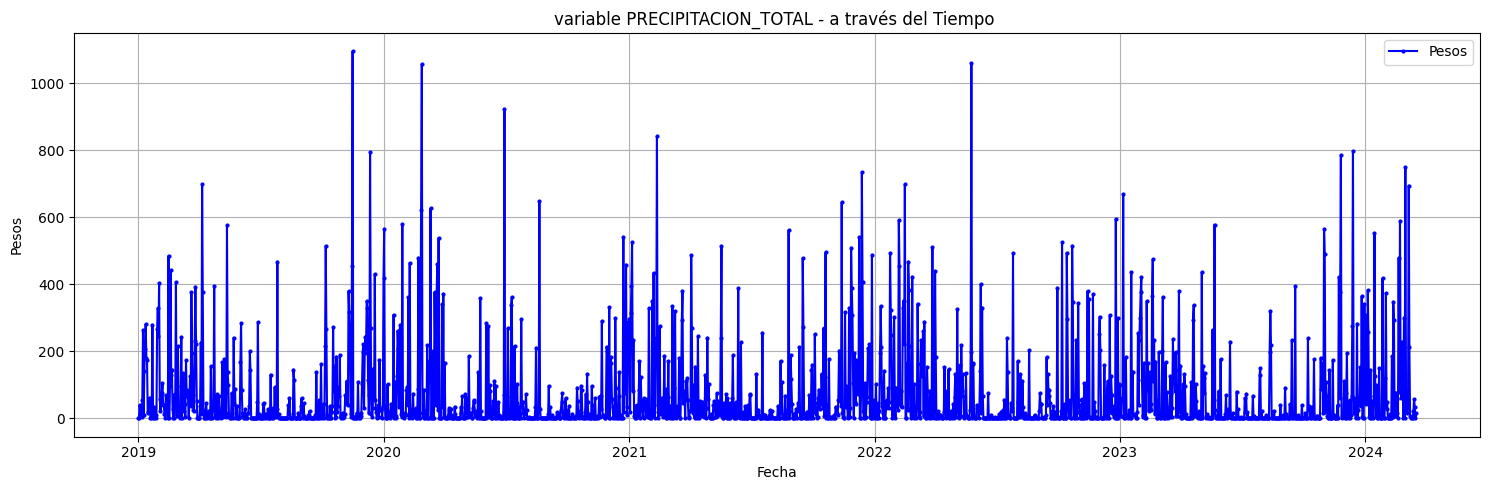

In [363]:
print(df_calidad_precipitacion_full.PLANTACION.unique())
function_tendencia_unica(df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Palmawasi'], 'PRECIPITACION_TOTAL','blue')
# function_tendencia_unica(df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Shanuzi'], 'PRECIPITACION_TOTAL','blue')

In [364]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_precip = df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Palmawasi']
# df_analisis_tendencia_precip = df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == 'Shanuzi']


df_analisis_tendencia_precip['FECHA'] = pd.to_datetime(df_analisis_tendencia_precip['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

print(df_analisis_tendencia_precip.PLANTACION.unique())
df_analisis_tendencia_precip.head()

['Palmawasi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\3343822288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['FECHA'] = pd.to_datetime(df_analisis_tendencia_precip['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\3343822288.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,PRECIPITACION_TOTAL,SEMANA
1,2019-01-01,Palmawasi,0.0,2018-12-31
3,2019-01-02,Palmawasi,0.0,2018-12-31
5,2019-01-03,Palmawasi,40.3,2018-12-31
7,2019-01-04,Palmawasi,12.5,2018-12-31
9,2019-01-05,Palmawasi,14.9,2018-12-31


In [365]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_semana_precip = df_analisis_tendencia_precip.groupby(['SEMANA','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_semana_precip.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
df_analisis_tendencia_semana_precip.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2018-12-31,Palmawasi,72.1
1,2019-01-07,Palmawasi,1139.6
2,2019-01-14,Palmawasi,320.3
3,2019-01-21,Palmawasi,335.3
4,2019-01-28,Palmawasi,1321.6


Analisis de  2018-12-31 00:00:00  hasta  2024-03-11 00:00:00


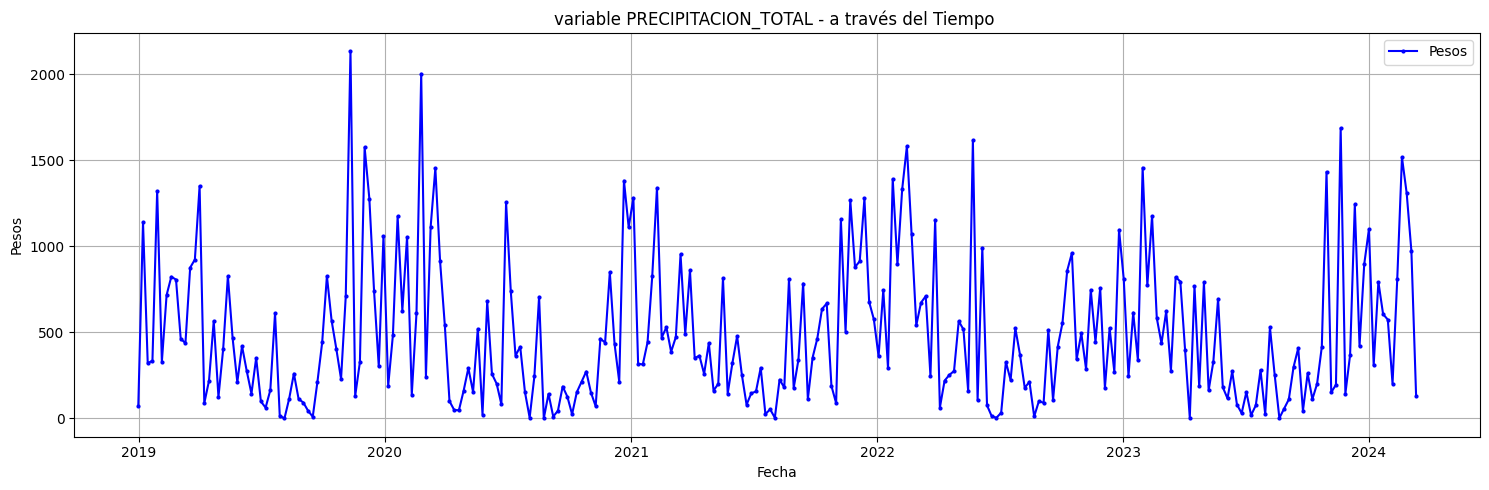

In [366]:
function_tendencia_unica(df_analisis_tendencia_semana_precip, 'PRECIPITACION_TOTAL','blue')

In [ ]:
df_filtrado_3 = df_analisis_tendencia_semana_precip

Calidad racimos propios

In [ ]:
print(df_analisis_tendencia_semana_2.PLANTACION.unique())
df_analisis_tendencia_semana_2.head()

In [ ]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi
fecha_limite = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi

# df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Palmawasi']['FECHA'] >= fecha_limite]
df_filtrado = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi'][df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == 'Shanuzi']['FECHA'] >= fecha_limite]

In [ ]:
#function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_MALFORMADOA','green')
function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_MALFORMADOB','green')

In [ ]:
print("df_analisis_tendencia_semana_precip: ",df_analisis_tendencia_semana_precip.FECHA.min())
print("df_analisis_tendencia_semana_2:", df_analisis_tendencia_semana_2.FECHA.min())

In [367]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_precip = pd.merge(df_analisis_tendencia_semana_precip,
                            df_analisis_tendencia_semana_2,
                            on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_precip['FECHA'] = pd.to_datetime(df_analisis_full_precip['FECHA'])
print(df_analisis_full_precip.PLANTACION.unique())
df_analisis_full_precip.head()

['Palmawasi']


,FECHA,PLANTACION,PRECIPITACION_TOTAL,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,...,%_SMADUROS,%_ESCOBAJO,%_MALFORMADOA,%_MALFORMADOB,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADOA,Peso_MALFORMADOB
0,2018-12-31,Palmawasi,72.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-07,Palmawasi,1139.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-14,Palmawasi,320.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-21,Palmawasi,335.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-28,Palmawasi,1321.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [368]:
# fecha_limite_sem = pd.Timestamp('2023-01-01') ## --> Para sede Palmawasi
fecha_limite_sem = pd.Timestamp('2021-01-01') ## --> Para sede Palmawasi

df_analisis_full_precip = df_analisis_full_precip[df_analisis_full_precip['FECHA'] >= fecha_limite_sem]
df_analisis_full_precip.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,...,%_SMADUROS,%_ESCOBAJO,%_MALFORMADOA,%_MALFORMADOB,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADOA,Peso_MALFORMADOB
105,2021-01-04,Palmawasi,1282.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,2021-01-11,Palmawasi,317.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,2021-01-18,Palmawasi,313.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,2021-01-25,Palmawasi,441.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,2021-02-01,Palmawasi,827.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


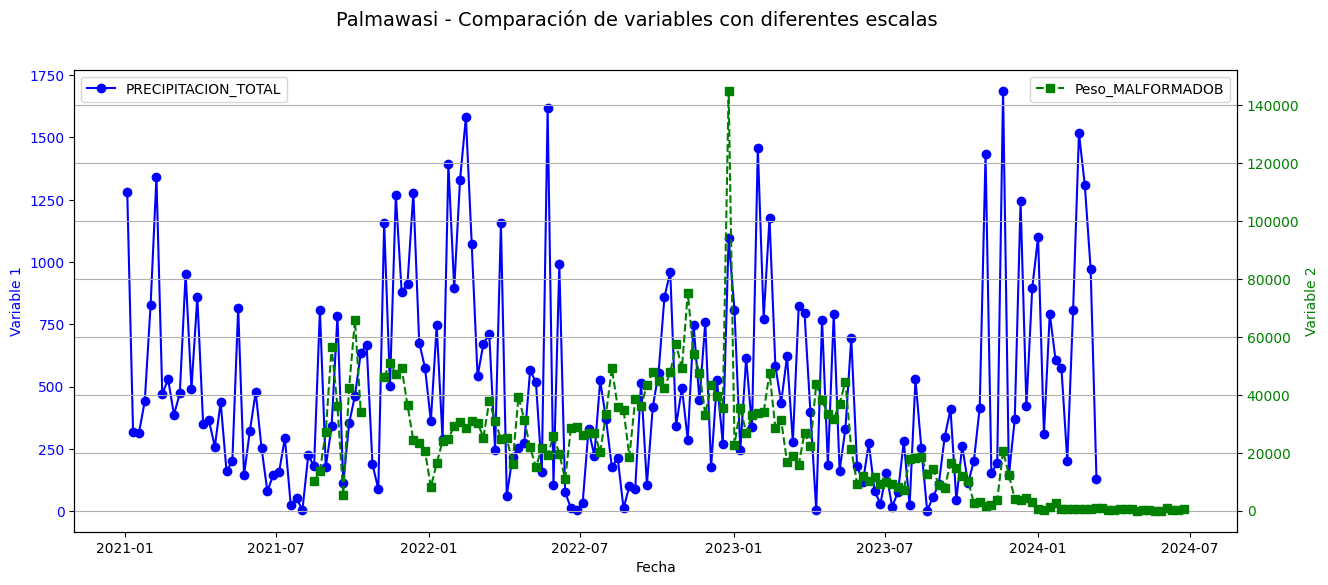

In [369]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA')
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



In [ ]:
df_analisis_full_precip['PRECIPITACION_TOTAL'].corr(df_analisis_full_precip['Peso_MALFORMADOA'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])


In [ ]:

# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_full_precip['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_3'] = df_analisis_full_precip['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_4'] = df_analisis_full_precip['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_VERDES_rolling_2'] = df_analisis_full_precip['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_VERDES_rolling_3'] = df_analisis_full_precip['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_VERDES_rolling_4'] = df_analisis_full_precip['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_MADUROS_rolling_2'] = df_analisis_full_precip['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_MADUROS_rolling_3'] = df_analisis_full_precip['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_MADUROS_rolling_4'] = df_analisis_full_precip['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_SMADUROS_rolling_2'] = df_analisis_full_precip['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_SMADUROS_rolling_3'] = df_analisis_full_precip['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_SMADUROS_rolling_4'] = df_analisis_full_precip['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

# --
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'] = df_analisis_full_precip['Peso_MALFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_MALFORMADOA_rolling_3'] = df_analisis_full_precip['Peso_MALFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_MALFORMADOA_rolling_4'] = df_analisis_full_precip['Peso_MALFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'] = df_analisis_full_precip['Peso_MALFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip['Peso_MALFORMADOB_rolling_3'] = df_analisis_full_precip['Peso_MALFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip['Peso_MALFORMADOB_rolling_4'] = df_analisis_full_precip['Peso_MALFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip.head()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2')
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()



In [ ]:
# Correlaciones analisis
# ----------
# ------
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_3'].corr(df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'])
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])



In [ ]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

# lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'])
lags, corr = correlacion_cruzada(df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])


In [ ]:
# lags, corr

# Crear el DataFrame correlaciones cruzadas
df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
function_save(df_lags_corr)
df_lags_corr.head()

In [ ]:

# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
# plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_MAFORMADOA_rolling_2"')
plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "Peso_MAFORMADOB_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()


In [ ]:

# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
# -- tipo A
# --
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_39'] = df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'].shift(-39)
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'] = df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'].shift(-40)
df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_41'] = df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'].shift(-41)
# --

# -- tipo B
# --
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_33'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-33)
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_39'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-39)
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-40)
df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_41'] = df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'].shift(-41)

df_analisis_full_precip.head()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2_SHIFTED_40')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2_SHIFTED_40')
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_33'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2_SHIFTED_33')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# tipo A
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MAFORMADOA_rolling_2'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'])

# -- tipo B
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'])
df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_33'])
# df_analisis_full_precip['PRECIPITACION_TOTAL_rolling_4'].corr(df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'])


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2_SHIFTED_40'], color='blue', marker='o', linestyle='-', label='Peso_MALFORMADOA_rolling_2_SHIFTED_40')
#ax1.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2_SHIFTED_40'], color='blue', marker='o', linestyle='-', label='Peso_MALFORMADOB_rolling_2_SHIFTED_40')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2')
# ax2.plot(df_analisis_full_precip['FECHA'], df_analisis_full_precip['Peso_MALFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2')

ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


Cruzando precipitación con TEA

In [372]:
# AÑADIENDO DATOS DE BALANZA Y FABRICA
# #######################
# #######################

fecha_limite_sem = pd.Timestamp('2016-01-01') ## --> Para sede Palmawasi
# fecha_limite_sem = pd.Timestamp('2016-01-01') ## --> Para sede Shanuzi

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_full_precip_tea = pd.merge(df_analisis_tendencia_semana,
                                       df_analisis_tendencia_semana_precip,
                                       on=['FECHA', 'PLANTACION'], how='outer')
# Convertir 'FECHA' a formato datetime
df_analisis_full_precip_tea['FECHA'] = pd.to_datetime(df_analisis_full_precip_tea['FECHA'])
df_analisis_full_precip_tea =  df_analisis_full_precip_tea[df_analisis_full_precip_tea['FECHA'] >= fecha_limite_sem]

print(df_analisis_full_precip_tea.PLANTACION.unique())
df_analisis_full_precip_tea.head()

['Palmawasi']


,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros,PRECIPITACION_TOTAL
0,2018-12-31,Palmawasi,3705.86,3153.19,552.67,810.31779,95.68221,906.00,0.244478,0.256983,0.173127,72.1
1,2019-01-07,Palmawasi,5839.39,5212.83,626.56,1301.01619,153.62381,1454.64,0.249108,0.249580,0.245186,1139.6
2,2019-01-14,Palmawasi,7789.37,7022.51,766.86,1722.95385,203.44615,1926.40,0.247311,0.245347,0.265298,320.3
3,2019-01-21,Palmawasi,6784.31,6167.43,616.88,1513.96162,178.76838,1692.73,0.249507,0.245477,0.289794,335.3
4,2019-01-28,Palmawasi,5765.91,5143.04,622.87,1228.89613,154.16387,1383.06,0.239868,0.238944,0.247506,1321.6


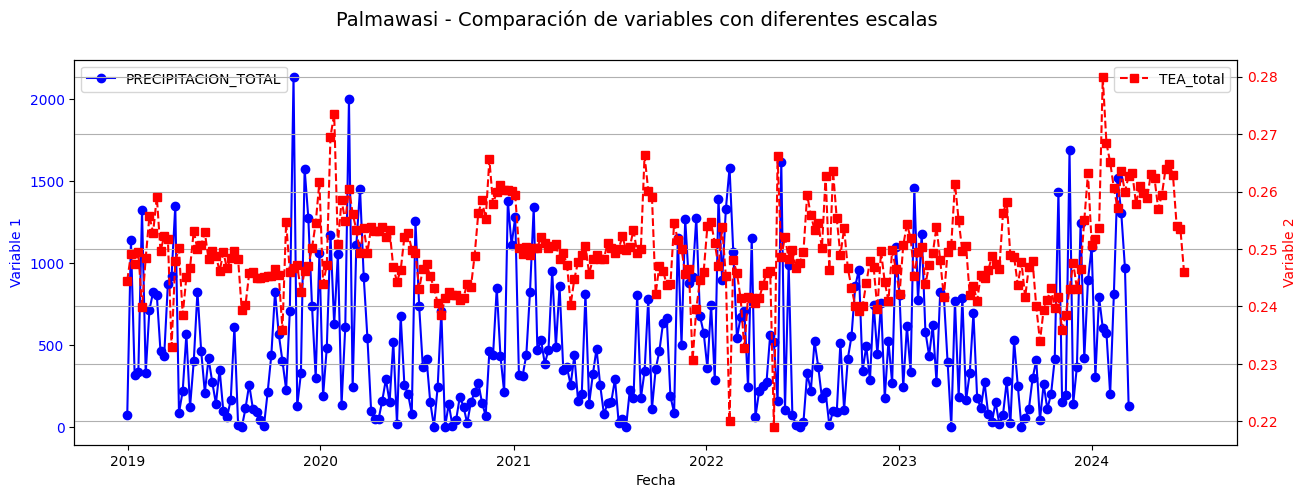

In [373]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 5))

plantacion_name = df_analisis_full_precip_tea['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['TEA_total'], color='red', marker='s', linestyle='--', label='TEA_total')

ax2.set_ylabel('Variable 2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
# function_tendencia_unica(df_analisis_full_precip_tea,'PRECIPITACION_TOTAL','blue')
function_tendencia_unica(df_analisis_full_precip_tea,'TEA_total','red')

In [376]:

# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_full_precip_tea['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_3'] = df_analisis_full_precip_tea['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_4'] = df_analisis_full_precip_tea['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip_tea['TEA_total_rolling_2'] = df_analisis_full_precip_tea['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full_precip_tea['TEA_total_rolling_3'] = df_analisis_full_precip_tea['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full_precip_tea['TEA_total_rolling_4'] = df_analisis_full_precip_tea['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full_precip_tea.head()



,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros,PRECIPITACION_TOTAL,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_3,PRECIPITACION_TOTAL_rolling_4,TEA_total_rolling_2,TEA_total_rolling_3,TEA_total_rolling_4
0,2018-12-31,Palmawasi,3705.86,3153.19,552.67,810.31779,95.68221,906.00,0.244478,0.256983,0.173127,72.1,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-07,Palmawasi,5839.39,5212.83,626.56,1301.01619,153.62381,1454.64,0.249108,0.249580,0.245186,1139.6,605.85,NaN,NaN,0.246793,NaN,NaN
2,2019-01-14,Palmawasi,7789.37,7022.51,766.86,1722.95385,203.44615,1926.40,0.247311,0.245347,0.265298,320.3,729.95,510.666667,NaN,0.248210,0.246966,NaN
3,2019-01-21,Palmawasi,6784.31,6167.43,616.88,1513.96162,178.76838,1692.73,0.249507,0.245477,0.289794,335.3,327.80,598.400000,466.825,0.248409,0.248642,0.247601
4,2019-01-28,Palmawasi,5765.91,5143.04,622.87,1228.89613,154.16387,1383.06,0.239868,0.238944,0.247506,1321.6,828.45,659.066667,779.200,0.244688,0.245562,0.246449


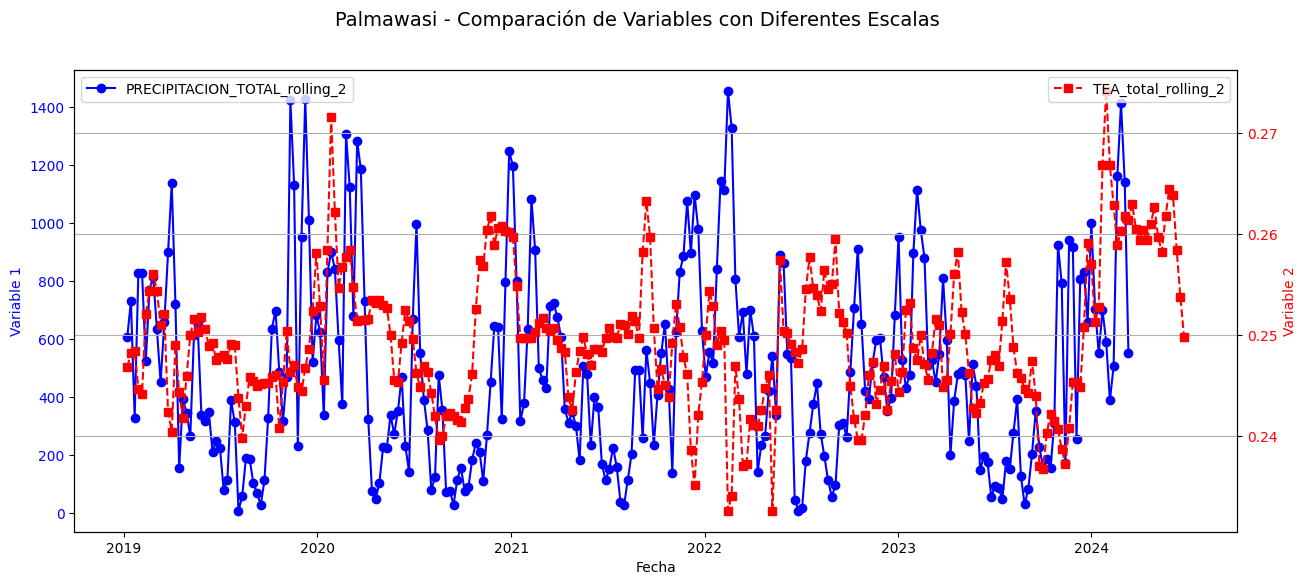

In [377]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full_precip_tea['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_full_precip_tea['FECHA'], df_analisis_full_precip_tea['TEA_total_rolling_2'], color='red', marker='s', linestyle='--', label='TEA_total_rolling_2')

ax2.set_ylabel('Variable 2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [378]:
# Correlaciones analisis
# ----------
# ------
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip_tea['TEA_total_rolling_2'])


0.09345280114974892

In [379]:
def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr

lags, corr = correlacion_cruzada(df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'], df_analisis_full_precip_tea['TEA_total_rolling_2'])


c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [380]:
# lags, corr

# Crear el DataFrame correlaciones cruzadas
df_lags_corr = pd.DataFrame({'lags': lags, 'corr': corr})
function_save(df_lags_corr)
df_lags_corr.head()


Datos guardados en C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx


,lags,corr
0,-286,NaN
1,-285,NaN
2,-284,-1.000000
3,-283,0.644227
4,-282,-0.127491


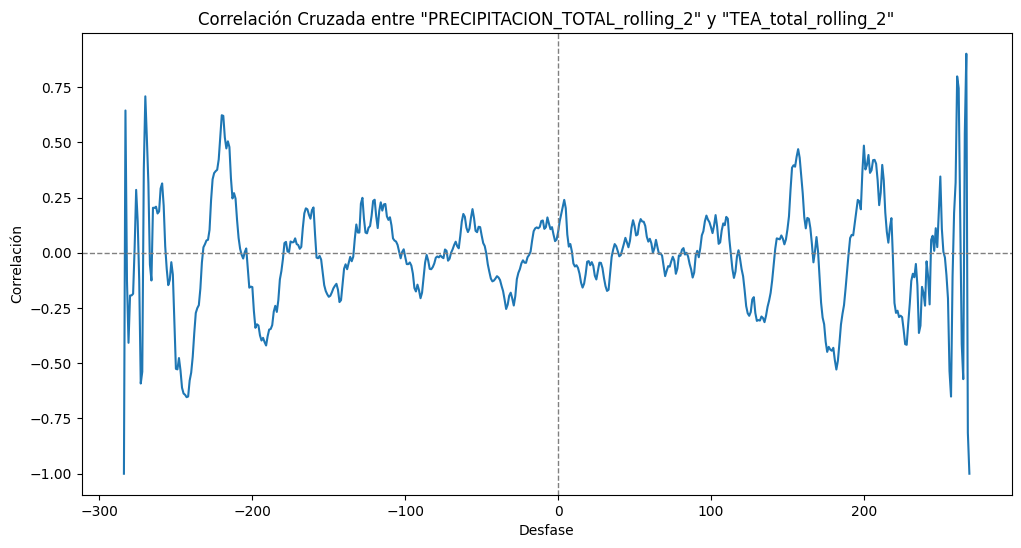

In [381]:
# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "PRECIPITACION_TOTAL_rolling_2" y "TEA_total_rolling_2"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()

In [382]:

# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
# -- Palmawasi
# --
df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_28'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-28)
df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_29'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-29)
df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_30'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-30)
# --

# -- Shanusi
# --
# df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_25'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-25)
# df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_26'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-26)
# df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_27'] = df_analisis_full_precip_tea['TEA_total_rolling_2'].shift(-27)


In [383]:
# Correlaciones analisis
# ----------
# ------
df_analisis_full_precip_tea['PRECIPITACION_TOTAL_rolling_2'].corr(df_analisis_full_precip_tea['TEA_total_rolling_2_SHIFTED_29'])


-0.23870752473597048

##### RELACION CALIDAD FRUTOS VS TEA

In [342]:
# Completando datos con Peso balanza de Propios y terceros
# ----
df_sabana_balanza_full['FECHA'] = pd.to_datetime(df_sabana_balanza_full['FECHA'])
df_sabana_balanza_full.head()

,PTANIO,PTNOMBREMES,"Date(PTDIA, 'DD/MM/YYYY')",PROPIOS,TERCEROS,TOTAL,PARTICIPACION CP,PLANTACION,FECHA
0,2024,Enero,2024-01-02 00:00:00,0.00,198.59,198.59,1.000000,Nuevo Horizonte,2024-01-02
1,2024,Enero,2024-01-03 00:00:00,23.23,252.48,275.71,0.915745,Nuevo Horizonte,2024-01-03
2,2024,Enero,2024-01-04 00:00:00,45.08,279.98,325.06,0.861318,Nuevo Horizonte,2024-01-04
3,2024,Enero,2024-01-05 00:00:00,38.77,286.39,325.16,0.880766,Nuevo Horizonte,2024-01-05
4,2024,Enero,2024-01-06 00:00:00,53.18,222.22,275.40,0.806899,Nuevo Horizonte,2024-01-06


In [343]:
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])
df_calidad_racimos_propios_full.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN


In [344]:
print(f'dimension inicial: {df_calidad_racimos_propios_full.shape}')

df_calidad_racimos_propios_full_v2 = pd.merge(df_calidad_racimos_propios_full,
                                              df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS']],
                                              on = ['FECHA','PLANTACION'],
                                              how = 'outer')

df_calidad_racimos_propios_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full_v2['FECHA'])
df_calidad_racimos_propios_full_v2['Peso_propios'] = df_calidad_racimos_propios_full_v2['PROPIOS']*1000
df_calidad_racimos_propios_full_v2['PCTJ'] = df_calidad_racimos_propios_full_v2['Peso']/df_calidad_racimos_propios_full_v2['Peso_propios']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(f'dimension final: {df_calidad_racimos_propios_full_v2.shape}')
df_calidad_racimos_propios_full_v2.head()

dimension inicial: (2362, 11)
dimension final: (6186, 14)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\381160290.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN
1,2020-01-02,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.66,625660.0,NaN
2,2020-01-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
3,2020-01-02,Tulumayo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
4,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN


In [ ]:
df_sabana_balanza_full.PLANTACION.unique()

In [345]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'
# sede_analisis = 'Tulumayo'

# -------
# ---


min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_propios_filter = df_calidad_racimos_propios_full_v2[df_calidad_racimos_propios_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])

print(df_calidad_racimos_propios_filter.PLANTACION.unique())
df_calidad_racimos_propios_filter.head()

df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2021-08-18 00:00:00
['Palmawasi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\3509797989.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
1,2020-01-02,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.66,625660.0,NaN
5,2020-01-03,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,777.49,777490.0,NaN
9,2020-01-04,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,905.85,905850.0,NaN
12,2020-01-05,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.30,87300.0,NaN
14,2020-01-06,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,824.40,824400.0,NaN


In [346]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite = pd.Timestamp('2021-08-18') ## --> Para sede Palmawasi
# fecha_limite = pd.Timestamp('2023-03-17') ## --> Para sede Shanuzi
# fecha_limite = pd.Timestamp('2022-01-03') ## --> Para sede Tulumayo

df_filtrado =  df_calidad_racimos_propios_filter[df_calidad_racimos_propios_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
2098,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,832.19,832190.0,NaN
2102,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,863.66,863660.0,NaN
2106,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,858.30,858300.0,NaN
2110,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,741.57,741570.0,NaN
2114,2021-08-22,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427.47,427470.0,NaN


In [348]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'Peso':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)

    AÑO          Peso
0  2021  0.000000e+00
1  2022  2.567501e+08
2  2023  2.367371e+08
3  2024  1.061616e+08
---------------------
    AÑO  PCTJ_AÑO
0  2021  0.966405
1  2022  0.966405
2  2023  1.027700
3  2024  1.043174


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\4170273943.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year


In [349]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,832.19,832190.0,NaN,2021,0.966405
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,863.66,863660.0,NaN,2021,0.966405
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,858.30,858300.0,NaN,2021,0.966405
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,741.57,741570.0,NaN,2021,0.966405
4,2021-08-22,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427.47,427470.0,NaN,2021,0.966405


In [350]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['Peso'].isna(), df_filtrado['Peso_propios'] * df_filtrado['PCTJ_AÑO'], df_filtrado['Peso'])
df_filtrado.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO,Peso_ajustado
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN,832.19,832190.0,NaN,2021,0.966405,804232.57695
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN,863.66,863660.0,NaN,2021,0.966405,834645.34230
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN,858.30,858300.0,NaN,2021,0.966405,829465.41150
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN,741.57,741570.0,NaN,2021,0.966405,716656.95585
4,2021-08-22,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,427.47,427470.0,NaN,2021,0.966405,413109.14535


In [351]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2 = df_filtrado
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M = df_analisis_tendencia_2
df_analisis_tendencia_2M['MES'] = df_analisis_tendencia_2M['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

In [ ]:
# df_analisis_tendencia_2.head()
df_analisis_tendencia_2M.head()


In [352]:
# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'VERDES':'sum',
                                                                                               'MADUROS':'sum',
                                                                                               'SMADUROS':'sum',
                                                                                               'ESCOBAJO':'sum',
                                                                                               'MALFORMADOA':'sum',
                                                                                               'MALFORMADOB':'sum',
                                                                                               'Peso': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Racimos':'sum',
                                                                                               'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']

# Agrupar por 'MES' y calcular la suma de 'VALOR1' y 'VALOR2'
df_analisis_tendencia_mes_2 = df_analisis_tendencia_2M.groupby(['MES','PLANTACION']).agg({'VERDES':'sum',
                                                                                          'MADUROS':'sum',
                                                                                          'SMADUROS':'sum',
                                                                                          'ESCOBAJO':'sum',
                                                                                          'MALFORMADOA':'sum',
                                                                                          'MALFORMADOB':'sum',
                                                                                          'Peso': 'sum',
                                                                                          'Peso_ajustado':'sum',
                                                                                          'Racimos':'sum',
                                                                                          'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_mes_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']



In [ ]:
df_analisis_tendencia_semana_2.head()
# df_analisis_tendencia_mes_2.head()


In [353]:
# Creando variables de calidad
# ----

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_semana_2['Peso_CALIDAD'] = df_analisis_tendencia_semana_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_semana_2['%_VERDES'] = df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MADUROS'] = df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_SMADUROS'] = df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_ESCOBAJO'] = df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOA'] = df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOB'] = df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']


df_analisis_tendencia_semana_2['Peso_VERDES'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_SMADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_ESCOBAJO'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOA'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOB'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])

df_analisis_tendencia_semana_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_semana_2['FECHA'])


# VARIABLES CALIDAD MES
# -------
# ---

df_analisis_tendencia_mes_2['Peso_CALIDAD'] = df_analisis_tendencia_mes_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_mes_2['Peso_VERDES'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['VERDES']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_MADUROS'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['MADUROS']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_SMADUROS'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['SMADUROS']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_ESCOBAJO'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['ESCOBAJO']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_MALFORMADOA'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['MALFORMADOA']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])
df_analisis_tendencia_mes_2['Peso_MALFORMADOB'] = df_analisis_tendencia_mes_2['Peso_ajustado']*(df_analisis_tendencia_mes_2['MALFORMADOB']/ df_analisis_tendencia_mes_2['Peso_CALIDAD'])

df_analisis_tendencia_mes_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_mes_2['FECHA'])


df_analisis_tendencia_semana_2.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Peso_ajustado,...,%_SMADUROS,%_ESCOBAJO,%_MALFORMADOA,%_MALFORMADOB,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADOA,Peso_MALFORMADOB
0,2021-08-16,Palmawasi,230.0,7887.0,344.0,0.0,248.0,24.0,0.0,3.598109e+06,...,0.040657,0.0,0.029311,0.002837,97809.380611,3.354011e+06,146288.812740,0.0,105464.027789,10206.196238
1,2021-08-23,Palmawasi,259.0,8663.0,528.0,0.0,267.0,31.0,0.0,4.178010e+06,...,0.055873,0.0,0.028254,0.003280,114508.433631,3.830064e+06,233438.042305,0.0,118045.373665,13705.642635
2,2021-08-30,Palmawasi,222.0,13006.0,558.0,0.0,411.0,89.0,0.0,4.214618e+06,...,0.040476,0.0,0.029813,0.006456,67869.226749,3.976158e+06,170590.218585,0.0,125649.784656,27208.834147
3,2021-09-06,Palmawasi,74.0,5423.0,278.0,0.0,176.0,61.0,0.0,5.358629e+06,...,0.048139,0.0,0.030476,0.010563,68664.680068,5.032008e+06,257956.500796,0.0,163310.590432,56601.966002
4,2021-09-13,Palmawasi,56.0,9044.0,441.0,0.0,280.0,61.0,0.0,5.660360e+06,...,0.046222,0.0,0.029347,0.006393,33222.947719,5.365506e+06,261630.713288,0.0,166114.738596,36189.282337


Analisis de  2021-08-16 00:00:00  hasta  2024-07-01 00:00:00


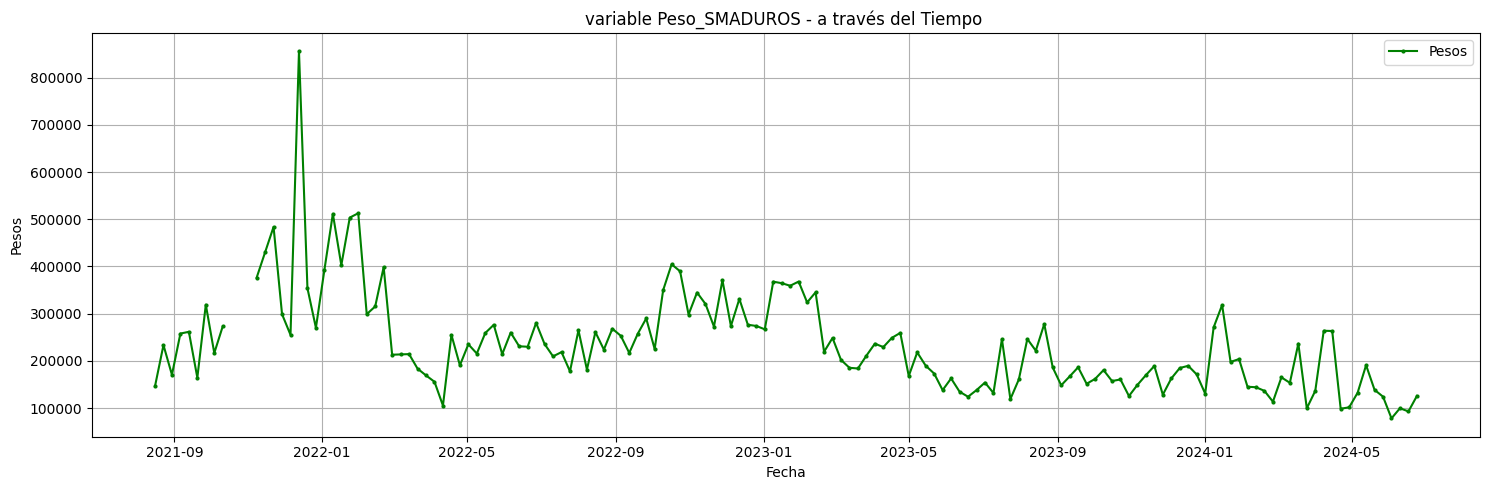

In [354]:
# function_tendencia_unica(df_analisis_tendencia_mes_2,'Peso_MADUROS','green')

# function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_MADUROS','green')
function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')



TEA SEMANAL Y MENSUAL - CASHCOST

In [355]:

# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'



# -------
# ---

df_participacion_tea =  df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == sede_analisis]
df_participacion_tea.head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
0,20190101,3002,PW,0.00,0.00,0.00,0.0,0.00000,0.00000,2019-01-01,Palmawasi
1,20190102,3002,PW,496.30,406.32,89.98,122.0,109.11564,12.88436,2019-01-02,Palmawasi
4,20190103,3002,PW,975.59,893.82,81.77,238.0,212.86494,25.13506,2019-01-03,Palmawasi
7,20190104,3002,PW,1130.29,937.82,192.47,278.0,248.64056,29.35944,2019-01-04,Palmawasi
10,20190105,3002,PW,1103.68,915.23,188.45,268.0,239.69665,28.30335,2019-01-05,Palmawasi


In [356]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia = df_participacion_tea

df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])

# Crear columna 'SEMANA'
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
# Crear columna 'MES'
df_analisis_tendencia['MES'] = df_analisis_tendencia['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)



# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                           'RFFProcesadoPropios':'sum',
                                                                                           'RFFProcesadoTerceros':'sum',
                                                                                           'CPOObtenidoPropios':'sum',
                                                                                           'CPOObtenidoTerceros':'sum',
                                                                                           'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_semana['TEA_total'] = df_analisis_tendencia_semana['CPOObtenido']/df_analisis_tendencia_semana['RFFProcesado']
df_analisis_tendencia_semana['TEA_propios'] = df_analisis_tendencia_semana['CPOObtenidoPropios']/df_analisis_tendencia_semana['RFFProcesadoPropios']
df_analisis_tendencia_semana['TEA_terceros'] = df_analisis_tendencia_semana['CPOObtenidoTerceros']/df_analisis_tendencia_semana['RFFProcesadoTerceros']


df_analisis_tendencia_mes = df_analisis_tendencia.groupby(['MES','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                     'RFFProcesadoPropios':'sum',
                                                                                     'RFFProcesadoTerceros':'sum',
                                                                                     'CPOObtenidoPropios':'sum',
                                                                                     'CPOObtenidoTerceros':'sum',
                                                                                     'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_mes.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_mes['TEA_total'] = df_analisis_tendencia_mes['CPOObtenido']/df_analisis_tendencia_mes['RFFProcesado']
df_analisis_tendencia_mes['TEA_propios'] = df_analisis_tendencia_mes['CPOObtenidoPropios']/df_analisis_tendencia_mes['RFFProcesadoPropios']
df_analisis_tendencia_mes['TEA_terceros'] = df_analisis_tendencia_mes['CPOObtenidoTerceros']/df_analisis_tendencia_mes['RFFProcesadoTerceros']



C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\1926947912.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['FECHA'] = pd.to_datetime(df_analisis_tendencia['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\1926947912.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_5288\1926947912.py:12: Set

Analisis de  2021-08-16 00:00:00  hasta  2024-07-01 00:00:00


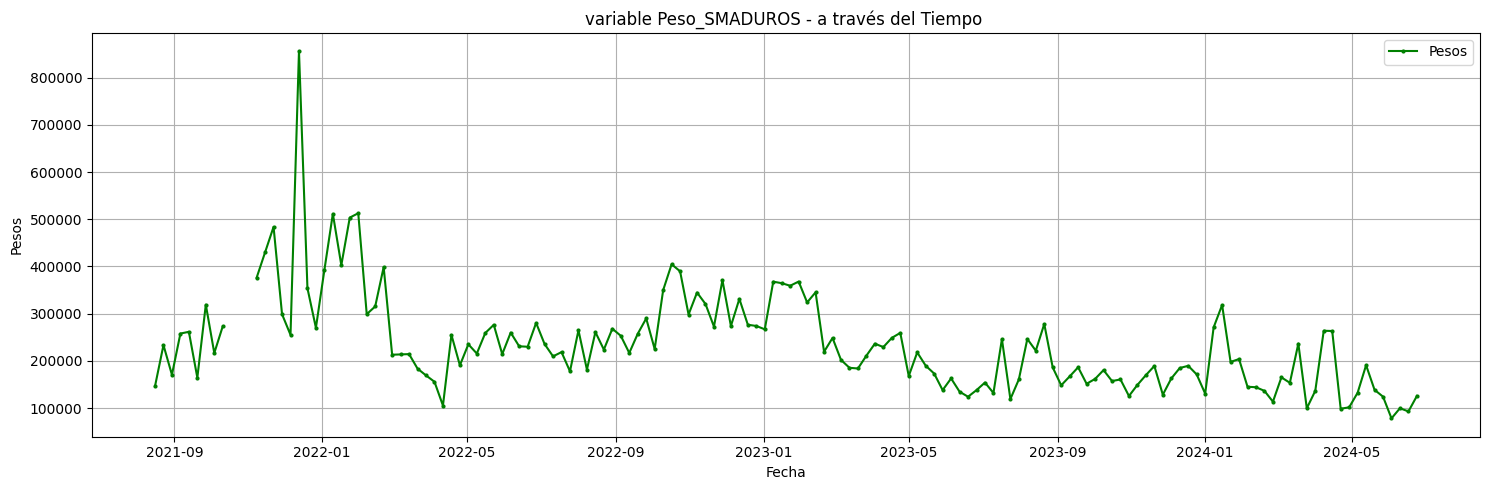

In [357]:
# Tendencias calidad de racimos
# ---------------
# ----------

function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')
# function_tendencia_unica(df_analisis_tendencia_mes_2,'Peso_MADUROS','green')

['Palmawasi']
Analisis de  2018-12-31 00:00:00  hasta  2024-06-24 00:00:00


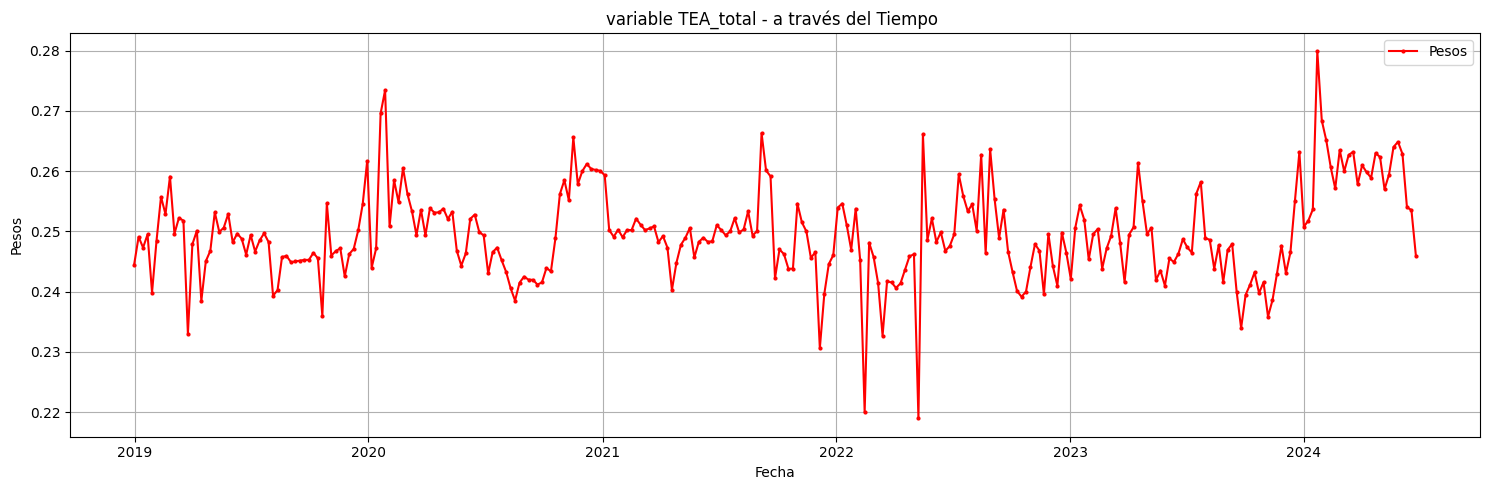

In [358]:
# Tendencias TEA
# ----------
# --------

print(df_analisis_tendencia_semana.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana,'TEA_total','red')
# function_tendencia_unica(df_analisis_tendencia_mes,'TEA_total','red')

In [359]:
# Ajustando datos segun las fechas de calidad de racimos
# ---------------------
# ---------------
# ---------

print(f'dimensión de base df_analisis_tendencia_semana_2: {df_analisis_tendencia_semana_2.FECHA.min()}')
print(f'dimensión de base df_analisis_tendencia_mes_2: {df_analisis_tendencia_mes_2.FECHA.min()}')

dimensión de base df_analisis_tendencia_semana_2: 2021-08-16 00:00:00
dimensión de base df_analisis_tendencia_mes_2: 2021-08-01 00:00:00


In [360]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite_sem = pd.Timestamp('2021-08-16') ## --> Para sede Palmawasi

# fecha_limite_mes = pd.Timestamp('2021-08-01') ## --> Para sede Palmawasi
# fecha_limite_mes = pd.Timestamp('2022-01-01') ## --> Para sede Palmawasi

# fecha_limite_mes = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi
# fecha_limite_sem = pd.Timestamp('2023-03-13') ## --> Para sede Shanuzi

df_filtrado_semana =  df_analisis_tendencia_semana[df_analisis_tendencia_semana['FECHA'] >= fecha_limite_sem]
# df_filtrado_mes =  df_analisis_tendencia_mes[df_analisis_tendencia_mes['FECHA'] >= fecha_limite_mes]

df_filtrado_semana.head()
# df_filtrado_mes.head()

,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros
137,2021-08-16,Palmawasi,5389.99,4713.22,676.77,1167.61645,197.98355,1365.60,0.253359,0.247732,0.292542
138,2021-08-23,Palmawasi,4122.53,3373.24,749.29,878.78186,149.00814,1027.79,0.249310,0.260516,0.198866
139,2021-08-30,Palmawasi,4282.87,3470.10,812.77,905.23803,165.79197,1071.03,0.250073,0.260868,0.203984
140,2021-09-06,Palmawasi,5542.96,4637.86,905.10,1244.22409,231.96591,1476.19,0.266318,0.268275,0.256288
141,2021-09-13,Palmawasi,6060.42,5176.98,883.44,1328.79683,247.73317,1576.53,0.260135,0.256674,0.280419


['Palmawasi']
Analisis de  2021-08-16 00:00:00  hasta  2024-06-24 00:00:00


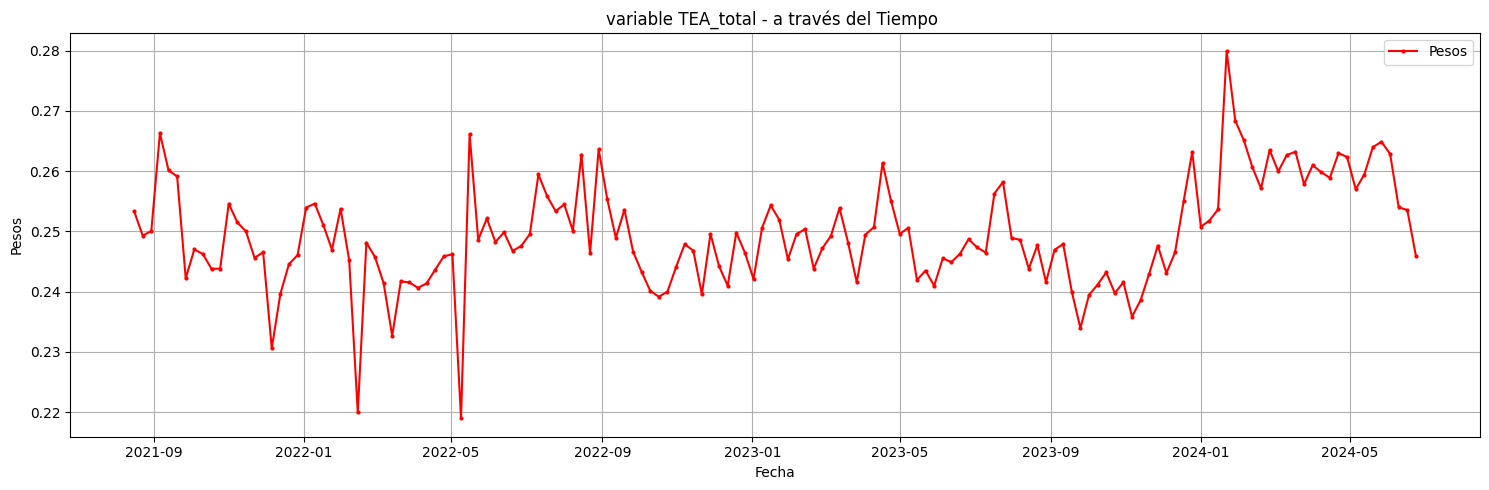

In [361]:
# Tendencias TEA filtrado 
# ----------
# --------
print(df_filtrado_semana.PLANTACION.unique())
function_tendencia_unica(df_filtrado_semana,'TEA_total','red')
# function_tendencia_unica(df_filtrado_mes,'TEA_total','red')
# function_tendencia_unica(df_filtrado_mes,'TEA_propios','blue')
# function_tendencia_unica(df_filtrado_mes,'TEA_terceros','blue')


In [ ]:
function_tendencia_unica(df_analisis_tendencia_semana_2,'Peso_SMADUROS','green')
# function_tendencia_unica(df_analisis_tendencia_mes_2,'Peso_MADUROS','green')


In [ ]:
# calidad racimos
# ----

df_analisis_tendencia_semana_2
df_analisis_tendencia_mes_2



# TEA
# ----
df_analisis_tendencia_semana
df_analisis_tendencia_mes

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full = pd.merge(df_analisis_tendencia_semana,
                                   df_analisis_tendencia_semana_2,
                                   on=['FECHA', 'PLANTACION'], how='outer')


df_analisis_semana_full = df_analisis_semana_full[df_analisis_semana_full['FECHA'] >= fecha_limite_sem]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full['FECHA'] = pd.to_datetime(df_analisis_semana_full['FECHA'])
print(df_analisis_semana_full.PLANTACION.unique())
df_analisis_semana_full.head()


# AÑADIENDO DATOS - ANALISIS MENSUAL
# #######################
# #######################

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
# df_analisis_mes_full = pd.merge(df_analisis_tendencia_mes,
#                                 df_analisis_tendencia_mes_2,
#                                 on=['FECHA', 'PLANTACION'], how='outer')


# df_analisis_mes_full = df_analisis_mes_full[df_analisis_mes_full['FECHA'] >= fecha_limite_mes]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
# df_analisis_mes_full['FECHA'] = pd.to_datetime(df_analisis_mes_full['FECHA'])
# print(df_analisis_mes_full.PLANTACION.unique())


In [ ]:
# Cuadramos BBDD para analizar
# -----------------
# --------------
# ----------

df_analisis_full = df_analisis_semana_full # ANALISIS SEMANAL
# df_analisis_full = df_analisis_mes_full # ANALISIS MENSUAL

df_analisis_full.head()

In [ ]:
# fecha_limite_mes = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi
fecha_limite_sem = pd.Timestamp('2023-03-13') ## --> Para sede Shanuzi

df_analisis_full =  df_analisis_full[df_analisis_full['FECHA'] >= fecha_limite_sem]
# df_filtrado_mes =  df_analisis_tendencia_mes[df_analisis_tendencia_mes['FECHA'] >= fecha_limite_mes]

df_analisis_full.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_total'], color='red', marker='o', linestyle='-', label='TEA')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('tea_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_filtrado_semana['FECHA'], df_filtrado_semana['Peso_MADUROS'], color='blue', marker='s', linestyle='--', label='Peso_MADUROS')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_MADUROS'], color='blue', marker='s', linestyle='--', label='%_MADUROS')


ax2.set_ylabel('Peso_SMADUROS', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de variables con diferentes escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()


In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_full['TEA_total_rolling_2'] = df_analisis_full['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['TEA_total_rolling_3'] = df_analisis_full['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['TEA_total_rolling_4'] = df_analisis_full['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_SMADUROS_rolling_2'] = df_analisis_full['Peso_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_SMADUROS_rolling_3'] = df_analisis_full['Peso_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_SMADUROS_rolling_4'] = df_analisis_full['Peso_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MADUROS_rolling_2'] = df_analisis_full['Peso_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MADUROS_rolling_3'] = df_analisis_full['Peso_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MADUROS_rolling_4'] = df_analisis_full['Peso_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos


df_analisis_full['Peso_VERDES_rolling_2'] = df_analisis_full['Peso_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_VERDES_rolling_3'] = df_analisis_full['Peso_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_VERDES_rolling_4'] = df_analisis_full['Peso_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos
df_analisis_full['Peso_VERDES_rolling_5'] = df_analisis_full['Peso_VERDES'].rolling(window=5).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MALFORMADOA_rolling_2'] = df_analisis_full['Peso_MALFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MALFORMADOA_rolling_3'] = df_analisis_full['Peso_MALFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MALFORMADOA_rolling_4'] = df_analisis_full['Peso_MALFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['Peso_MALFORMADOB_rolling_2'] = df_analisis_full['Peso_MALFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['Peso_MALFORMADOB_rolling_3'] = df_analisis_full['Peso_MALFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['Peso_MALFORMADOB_rolling_4'] = df_analisis_full['Peso_MALFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos


# -----------
# ----

df_analisis_full['%_SMADUROS_rolling_2'] = df_analisis_full['%_SMADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_SMADUROS_rolling_3'] = df_analisis_full['%_SMADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_SMADUROS_rolling_4'] = df_analisis_full['%_SMADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_MADUROS_rolling_2'] = df_analisis_full['%_MADUROS'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_MADUROS_rolling_3'] = df_analisis_full['%_MADUROS'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_MADUROS_rolling_4'] = df_analisis_full['%_MADUROS'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_VERDES_rolling_2'] = df_analisis_full['%_VERDES'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_VERDES_rolling_3'] = df_analisis_full['%_VERDES'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_VERDES_rolling_4'] = df_analisis_full['%_VERDES'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_MALFORMADOA_rolling_2'] = df_analisis_full['%_MALFORMADOA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_MALFORMADOA_rolling_3'] = df_analisis_full['%_MALFORMADOA'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_MALFORMADOA_rolling_4'] = df_analisis_full['%_MALFORMADOA'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_full['%_MALFORMADOB_rolling_2'] = df_analisis_full['%_MALFORMADOB'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_full['%_MALFORMADOB_rolling_3'] = df_analisis_full['%_MALFORMADOB'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_full['%_MALFORMADOB_rolling_4'] = df_analisis_full['%_MALFORMADOB'].rolling(window=4).mean() # Suavizado a 4 periodos




In [ ]:
df_analisis_full.columns

In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MALFORMADOA_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOA_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MALFORMADOB_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MALFORMADOB_rolling_2')

# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_MADUROS_rolling_2'], color='blue', marker='s', linestyle='--', label='%_MADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_SMADUROS_rolling_2'], color='blue', marker='s', linestyle='--', label='%_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['%_VERDES_rolling_2'], color='blue', marker='s', linestyle='--', label='%_VERDES_rolling_2')


ax2.set_ylabel('Peso_SMADUROS', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
function_save(df_analisis_full)

In [ ]:
## Analizando correlaciones
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_VERDES_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_MALFORMADOA_rolling_2'])
# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['Peso_MALFORMADOB_rolling_2'])

# df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['%_MADUROS_rolling_2'])
df_analisis_full['TEA_total_rolling_2'].corr(df_analisis_full['%_VERDES_rolling_2'])

In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA_total_rolling_2'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=4).corr(df_x['TEA_total_rolling_2'])
    function_save(correlation_df)

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(15, 3))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [ ]:
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total','Peso_MADUROS']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_SMADUROS_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_VERDES_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_MALFORMADOA_rolling_2']]
df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','Peso_MALFORMADOB_rolling_2']]

# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','%_MADUROS_rolling_2']]
# df_analisis_full_prueba = df_analisis_full[['FECHA','TEA_total_rolling_2','%_SMADUROS_rolling_2']]

df_analisis_full_prueba.set_index('FECHA',inplace=True)
df_analisis_full_prueba.head()


In [ ]:
function_correlacion_cruzada(df_analisis_full_prueba)

Quitando el componente estacional de las series de tiempo

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

serie1 = df_analisis_full_prueba['TEA_total_rolling_2']
serie2 = df_analisis_full_prueba['Peso_MADUROS_rolling_2']

# Interpolar valores faltantes en ambas series
serie1_interpolated = serie1.interpolate().fillna(method='bfill')
serie2_interpolated = serie2.interpolate().fillna(method='bfill')

# Alinear temporalmente las series para que tengan la misma longitud
aligned_data = pd.concat([serie1_interpolated, serie2_interpolated], axis=1).dropna()
serie1_aligned = aligned_data['TEA_total_rolling_2']
serie2_aligned = aligned_data['Peso_MADUROS_rolling_2']


In [ ]:
# Descomposición de la primera serie después de interpolar y alinear
result1 = seasonal_decompose(serie1_aligned, model='additive', period=12)
result1.plot()
plt.show()

# Descomposición de la segunda serie después de interpolar y alinear
result2 = seasonal_decompose(serie2_aligned, model='additive', period=12)
result2.plot()
plt.show()

In [ ]:
# Correlación de componentes residuales
serie1_deseasonalized = serie1_aligned - result1.seasonal
serie2_deseasonalized = serie2_aligned - result2.seasonal

# Calcular la correlación entre los componentes residuales
correlation = np.corrcoef(serie1_deseasonalized, serie2_deseasonalized)[0, 1]
print(f'Correlación entre las componentes residuales: {correlation}')

In [ ]:
function_save(df_analisis_full)

In [ ]:
lags, corr = correlacion_cruzada(df_analisis_full['TEA_total_rolling_3'], df_analisis_full['Peso_MADUROS_rolling_3'])

# Graficar correlación cruzada
plt.figure(figsize=(12, 6))
plt.plot(lags, corr)
plt.title('Correlación Cruzada entre "TEA_total_rolling_3" y "Peso_MADUROS_rolling_3"')
plt.xlabel('Desfase')
plt.ylabel('Correlación')
plt.axvline(0, color='gray', linestyle='--', linewidth=1)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.show()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

plantacion_name = df_analisis_full['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
# ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA'], color='blue', marker='o', linestyle='-', label='TEA')
ax1.plot(df_analisis_full['FECHA'], df_analisis_full['TEA_rolling_2'], color='blue', marker='o', linestyle='-', label='TEA_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_MADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_MADUROS_rolling_2')
ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_SMADUROS_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_SMADUROS_rolling_2')
# ax2.plot(df_analisis_full['FECHA'], df_analisis_full['Peso_VERDES_rolling_2'], color='green', marker='s', linestyle='--', label='Peso_VERDES')


ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# df_analisis_full['TEA'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])
df_analisis_full['TEA'].corr(df_analisis_full['Peso_SMADUROS_rolling_2'])
# df_analisis_full['TEA'].corr(df_analisis_full['Peso_VERDES_rolling_2'])

# df_analisis_full['TEA_rolling_2'].corr(df_analisis_full['Peso_MADUROS_rolling_2'])


In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=10).corr(df_x['TEA'])

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [ ]:
df_analisis_full.columns

In [ ]:
df_analisis_full_corr_columns = ['FECHA','CPOObtenido', 'TEA','Peso_VERDES', 'Peso_MADUROS','Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MAFORMADOA', 'Peso_MAFORMADOB']

df_analisis_full_corr = df_analisis_full[df_analisis_full_corr_columns]
df_analisis_full_corr.set_index('FECHA', inplace=True)

df_analisis_full_corr.head()


In [ ]:
# Calcular la matriz de correlación entre las variables
matriz_correlacion = df_analisis_full_corr.corr()

In [ ]:

plt.figure(figsize=(10, 6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de correlación entre las variables')
plt.show()

In [ ]:
function_correlacion_cruzada(df_analisis_full_corr)

##### ANALISIS SALDO EN CAMPO

In [ ]:
print(df_sabana_saldo_campo_full_vf.PLANTACION.unique())
df_sabana_saldo_campo_full_vf.head()

In [ ]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'

# -------
# ---


In [ ]:
df_sabana_saldo_campo_full_vf_filter = df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == sede_analisis]
df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

print(df_sabana_saldo_campo_full_vf_filter.PLANTACION.unique())
df_sabana_saldo_campo_full_vf_filter.head()


In [ ]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2M_saldo_campo['MES'] = df_analisis_tendencia_2M_saldo_campo['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

df_analisis_tendencia_2_saldo_campo.head()

In [ ]:
# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_saldo_campo = df_analisis_tendencia_2_saldo_campo.groupby(['SEMANA','PLANTACION']).agg({'SALDO':'sum',
                                                                                                                       'SALDO > 3':'sum'}).reset_index()

df_analisis_tendencia_semana_2_saldo_campo.columns = ['FECHA','PLANTACION', 'SALDO', 'SALDO > 3']
df_analisis_tendencia_semana_2_saldo_campo.head()

In [ ]:
function_save(df_analisis_tendencia_semana_2_saldo_campo)

In [ ]:
    # function_tendencia_unica(df_analisis_tendencia_semana_2_saldo_campo,'SALDO','black')
function_tendencia_unica(df_analisis_tendencia_semana_2_saldo_campo,'SALDO > 3','black')


In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite_sem = pd.Timestamp('2023-03-01') ## --> Para sede Palmawasi
# fecha_limite_sem = pd.Timestamp('2023-03-01') ## --> Para sede Shanusi


# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_saldo_campo = pd.merge(df_analisis_tendencia_semana_2_saldo_campo,
                                               df_analisis_tendencia_semana,
                                               on=['FECHA', 'PLANTACION'], how='outer')

df_analisis_semana_full_saldo_campo = df_analisis_semana_full_saldo_campo[df_analisis_semana_full_saldo_campo['FECHA'] >= fecha_limite_sem]
# fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_semana_full_saldo_campo['FECHA'])
print(df_analisis_semana_full_saldo_campo.PLANTACION.unique())
df_analisis_semana_full_saldo_campo.head()


In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_saldo_campo['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO'], color='black', marker='s', linestyle='--', label='SALDO')
ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO > 3'], color='black', marker='s', linestyle='--', label='SALDO > 3')


ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_semana_full_saldo_campo['TEA_total_rolling_2'] = df_analisis_semana_full_saldo_campo['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_saldo_campo['TEA_total_rolling_3'] = df_analisis_semana_full_saldo_campo['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_saldo_campo['TEA_total_rolling_4'] = df_analisis_semana_full_saldo_campo['TEA_total'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_saldo_campo['SALDO_rolling_2'] = df_analisis_semana_full_saldo_campo['SALDO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_saldo_campo['SALDO_rolling_3'] = df_analisis_semana_full_saldo_campo['SALDO'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_saldo_campo['SALDO_rolling_4'] = df_analisis_semana_full_saldo_campo['SALDO'].rolling(window=4).mean() # Suavizado a 4 periodos

df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_2'] = df_analisis_semana_full_saldo_campo['SALDO > 3'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_3'] = df_analisis_semana_full_saldo_campo['SALDO > 3'].rolling(window=3).mean() # Suavizado a 3 periodos
df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_4'] = df_analisis_semana_full_saldo_campo['SALDO > 3'].rolling(window=4).mean() # Suavizado a 4 periodos


In [ ]:
function_save(df_analisis_semana_full_saldo_campo)

In [ ]:

# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_saldo_campo['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO_rolling_2'], color='black', marker='s', linestyle='--', label='SALDO_rolling_2')
ax2.plot(df_analisis_semana_full_saldo_campo['FECHA'], df_analisis_semana_full_saldo_campo['SALDO > 3_rolling_2'], color='black', marker='s', linestyle='--', label='SALDO > 3_rolling_2')


ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'{plantacion_name[0]} - Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
def function_correlacion_cruzada(df_x):
    # Excluir la columna 'TEA' para calcular la correlación con las variables explicativas temporales
    df_explicativas = df_x.drop(columns=['TEA_total_rolling_2'])

    # Calcular la correlación entre TEA y cada variable explicativa temporal utilizando rolling().corr()
    correlation_df = df_explicativas.rolling(window=4).corr(df_x['TEA_total_rolling_2'])
    function_save(correlation_df)

    # Mostrar el DataFrame de correlaciones
    print(correlation_df)

    # Crear un gráfico de calor para visualizar las correlaciones
    plt.figure(figsize=(15, 3))
    sns.heatmap(correlation_df.T, annot=False, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlación entre TEA y Variables Explicativas Temporales')
    plt.xlabel('Puntos Temporales')
    plt.ylabel('Variables Explicativas Temporales')
    plt.show()

In [ ]:
df_analisis_full_prueba = df_analisis_semana_full_saldo_campo[['FECHA','TEA_total_rolling_2','SALDO > 3_rolling_2']]

df_analisis_full_prueba.set_index('FECHA',inplace=True)
df_analisis_full_prueba.head()


In [ ]:
function_correlacion_cruzada(df_analisis_full_prueba)

##### ANALISIS PERDIDAS ACEITE

In [ ]:
print(df_perdida_aceite_full.PLANTACION.unique())
df_perdida_aceite_full.head()

In [ ]:
# Variable pérdidas
# ---------

df_perdida_aceite_full.columns

# TM ACEITE CONDENSADO

# TM ACEITE ESCOBAJO SIN PICAR
# TM ACEITE ESCOBAJO PICADO

# TM ACEITE RACIMO MAL DESFRUTADO

# TM ACEITE FIBRA

# TM ACEITE AGUA TD

# TM ACEITE SOLIDO TD

# TM ACEITE EN ARENA

# TM ACEITE CASCARA

# Hay nuevas perdidas que no los quieren conciderar
# ----------
# TM RACIMOS DUROS
# TM RACIMOS MAL DESFRUTADOS

In [ ]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
sede_analisis = 'Palmawasi'
# sede_analisis = 'Shanuzi'

# -------
# ---


In [ ]:
# Filtrando la base total por sedes
# --------

# Creamos PERDIDA EN ACEITE ESCOBAJO
# ----
df_perdida_aceite_full['TM ACEITE ESCOBAJO'] = df_perdida_aceite_full['TM ACEITE ESCOBAJO SIN PICAR'] + df_perdida_aceite_full['TM ACEITE ESCOBAJO PICADO']
df_perdida_aceite_full['TM PERDIDA TOTAL'] = df_perdida_aceite_full['TM ACEITE CONDENSADO']+df_perdida_aceite_full['TM ACEITE ESCOBAJO']+df_perdida_aceite_full['TM ACEITE RACIMO MAL DESFRUTADO']+df_perdida_aceite_full['TM ACEITE FIBRA']+df_perdida_aceite_full['TM ACEITE AGUA TD']+df_perdida_aceite_full['TM ACEITE SOLIDO TD']+df_perdida_aceite_full['TM ACEITE EN ARENA']+df_perdida_aceite_full['TM ACEITE CASCARA']
# ----

df_perdida_aceite_full_filter = df_perdida_aceite_full[df_perdida_aceite_full['PLANTACION'] == sede_analisis]
df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])

print(df_perdida_aceite_full_filter.PLANTACION.unique())
df_perdida_aceite_full_filter.head()


In [ ]:
# function_tendencia_unica(df_perdida_aceite_full_filter,'TM ACEITE CONDENSADO','black')
# function_tendencia_unica(df_perdida_aceite_full_filter,'TM ACEITE ESCOBAJO','black')
function_tendencia_unica(df_perdida_aceite_full_filter,'TM PERDIDA TOTAL','black')


In [ ]:

## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Crear columna 'MES' que indica el año y el mes del año
df_analisis_tendencia_2M_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2M_perdida_aceite['MES'] = df_analisis_tendencia_2M_perdida_aceite['FECHA'].dt.to_period('M').apply(lambda r: r.start_time)

df_analisis_tendencia_2_perdida_aceite.head()


In [ ]:
# Tipos de perdidas en aceite - Fabrica
# ----------

# TM PERDIDA TOTAL

# TM ACEITE CONDENSADO
# TM ACEITE ESCOBAJO
# TM ACEITE RACIMO MAL DESFRUTADO
# TM ACEITE FIBRA
# TM ACEITE AGUA TD
# TM ACEITE SOLIDO TD
# TM ACEITE EN ARENA
# TM ACEITE CASCARA

In [ ]:

# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_perdida_aceite = df_analisis_tendencia_2_perdida_aceite.groupby(['SEMANA','PLANTACION']).agg({'TM PERDIDA TOTAL':'sum',
                                                                                                                             'TM ACEITE CONDENSADO':'sum',
                                                                                                                             'TM ACEITE ESCOBAJO':'sum',
                                                                                                                             'TM ACEITE RACIMO MAL DESFRUTADO':'sum',
                                                                                                                             'TM ACEITE FIBRA':'sum',
                                                                                                                             'TM ACEITE AGUA TD':'sum',
                                                                                                                             'TM ACEITE SOLIDO TD':'sum',
                                                                                                                             'TM ACEITE EN ARENA':'sum',
                                                                                                                             'TM ACEITE CASCARA':'sum'}).reset_index()

df_analisis_tendencia_semana_2_perdida_aceite.columns = ['FECHA','PLANTACION','TM PERDIDA TOTAL' ,'TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO','TM ACEITE RACIMO MAL DESFRUTADO', 'TM ACEITE FIBRA','TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD', 'TM ACEITE EN ARENA','TM ACEITE CASCARA']
df_analisis_tendencia_semana_2_perdida_aceite.head()



In [ ]:
# function_tendencia_unica(df_analisis_tendencia_semana_2_perdida_aceite,'TM ACEITE CONDENSADO','black')
function_tendencia_unica(df_analisis_tendencia_semana_2_perdida_aceite,'TM PERDIDA TOTAL','black')


In [ ]:
df_analisis_tendencia_semana.head()

In [ ]:
print(df_analisis_tendencia_semana.PLANTACION.unique())
function_tendencia_unica(df_analisis_tendencia_semana,'TEA_total','red')

In [ ]:
# AÑADIENDO DATOS - ANALISIS SEMANAL
# #######################
# #######################

# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
fecha_limite_sem = pd.Timestamp('2022-07-01') ## --> Para sede Palmawasi
# fecha_limite_sem = pd.Timestamp('2023-10-01') ## --> Para sede Shanusi
# fecha_limite_sem_2 = pd.Timestamp('2024-07-01') ## --> Para sede Shanusi

# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_analisis_semana_full_perdida_aceite = pd.merge(df_analisis_tendencia_semana,
                                               df_analisis_tendencia_semana_2_perdida_aceite,
                                               on=['FECHA', 'PLANTACION'], how='outer')

df_analisis_semana_full_perdida_aceite = df_analisis_semana_full_perdida_aceite[df_analisis_semana_full_perdida_aceite['FECHA'] >= fecha_limite_sem]
#df_analisis_semana_full_perdida_aceite = df_analisis_semana_full_perdida_aceite[df_analisis_semana_full_perdida_aceite['FECHA'] <= fecha_limite_sem_2]
#  fecha_limite_mes

# Convertir 'FECHA' a formato datetime
df_analisis_semana_full_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_semana_full_perdida_aceite['FECHA'])
print(df_analisis_semana_full_perdida_aceite.PLANTACION.unique())
df_analisis_semana_full_perdida_aceite.head()


In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(20, 5))

plantacion_name = df_analisis_semana_full_perdida_aceite['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TEA_total'], color='red', marker='o', linestyle='-', label='TEA_total')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO'], color='black', marker='s', linestyle='--', label='TM ACEITE CONDENSADO')

ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
function_save(df_analisis_semana_full_perdida_aceite)

In [ ]:
df_analisis_semana_full_perdida_aceite.columns

In [ ]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_semana_full_perdida_aceite['TEA_total_rolling_2'] = df_analisis_semana_full_perdida_aceite['TEA_total'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TEA_total_rolling_3'] = df_analisis_semana_full_perdida_aceite['TEA_total'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA'].rolling(window=3).mean() # Suavizado a 3 periodos

df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA_rolling_2'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA_rolling_3'] = df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA'].rolling(window=3).mean() # Suavizado a 3 periodos



In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 5))

plantacion_name = df_analisis_semana_full_perdida_aceite['PLANTACION'].unique()

# Graficar la primera variable en el eje principal
ax1.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TEA_total_rolling_2'], color='red', marker='o', linestyle='-', label='TEA_total_rolling_2')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('TEA_total', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Crear eje secundario
ax2 = ax1.twinx()
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM PERDIDA TOTAL_rolling_2'], color='black', marker='s', linestyle='--', label='TM PERDIDA TOTAL_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE CONDENSADO_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE CONDENSADO_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE ESCOBAJO_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE ESCOBAJO_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE RACIMO MAL DESFRUTADO_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE RACIMO MAL DESFRUTADO_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE FIBRA_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE FIBRA_rolling_2')

# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE AGUA TD_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE AGUA TD_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE SOLIDO TD_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE SOLIDO TD_rolling_2')
# ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE EN ARENA_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE EN ARENA_rolling_2')
ax2.plot(df_analisis_semana_full_perdida_aceite['FECHA'], df_analisis_semana_full_perdida_aceite['TM ACEITE CASCARA_rolling_2'], color='black', marker='s', linestyle='--', label='TM ACEITE CASCARA_rolling_2')


ax2.set_ylabel('var', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar títulos y leyendas
fig.suptitle(f'Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
df_analisis_semana_full_perdida_aceite.columns

##### OTRO ANALISIS

In [ ]:
# Analizando datos por Plantacion
# ----
df_TEA_full_tendencia = df_calidad_racimos_propios_full_group[df_calidad_racimos_propios_full_group['PLANTACION'] == 'Palmawasi']
# ---
df_TEA_full_tendencia = df_TEA_full_tendencia[df_TEA_full_tendencia['SECTOR'] == 'SE03']
# ---

function_tendencia_unica(df_TEA_full_tendencia,'Peso')

In [ ]:
df_TEA_full.head()

In [ ]:
print(df_TEA_full['PLANTACION'].unique())
df_TEA_full.head()

In [ ]:
function_tendencia_unica(df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte'], 'PROPIOS')

In [ ]:
# Filtramos la tendencia de interes DE LA BBDD UNIDA
# ################
# ################
# ################

# ---
df_TEA_full_tendencia = df_TEA_full[df_TEA_full['PLANTACION'] == 'Nuevo Horizonte']
df_TEA_full_tendencia = df_TEA_full_tendencia.sort_values(by='FECHA')
# ---

plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
plt.title('RFF Procesado por Día a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Fecha')
plt.ylabel('RFF Procesado por Día')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
# ---
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')

# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

In [ ]:
# Duplicando informacion faltante
# -----
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']]
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte.dropna(subset=['CPO OBTENIDO'])
df_TEA_full_tendencia_recorte = df_TEA_full_tendencia_recorte[df_TEA_full_tendencia_recorte['FECHA'] <= '2023-12-31']
# Lista de años a los que quieres copiar los datos
years_to_fill = [2019, 2020, 2021, 2022]

dfs_real = df_TEA_full_tendencia[['FECHA','CPO OBTENIDO']][df_TEA_full_tendencia['FECHA'] > '2023-01-01']

dfs = []
for year in years_to_fill:
    df_copy = df_TEA_full_tendencia_recorte.copy()
    # Ajustar el año mientras se maneja el caso especial del 29 de febrero
    def replace_year(date):
        try:
            return date.replace(year=year)
        except ValueError:
            # Manejar el 29 de febrero para años no bisiestos
            return date.replace(year=year, day=28)
    
    df_copy['FECHA'] = df_copy['FECHA'].apply(replace_year)
    dfs.append(df_copy)

# Concatenar todos los DataFrames
df_combined = pd.concat(dfs, ignore_index=True)
df_final = pd.concat([df_combined,dfs_real], ignore_index=True)

df_final.columns = ['FECHA','CPO OBTENIDO imp']
df_final.head()

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_tendencia = pd.merge(df_TEA_full_tendencia,
                                 df_final, 
                                 on='FECHA', 
                                 how='left')

In [ ]:
df_TEA_full_tendencia.head()

In [ ]:
plantacion_name = df_TEA_full_tendencia['PLANTACION'].unique()


# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO'], marker='o', markersize=4, label='CPO OBTENIDO')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')


# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
# plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['TERCEROS'], marker='o', markersize=4, label='TERCEROS')
plt.plot(df_TEA_full_tendencia['FECHA'], df_TEA_full_tendencia['PRECIPITACION_TOTAL'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de RFF PROCESADO y CPO OBTENIDO a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

#### Agrupando por semanas

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_tendencia['SEMANA'] = df_TEA_full_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_tendencia.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_semana = df_TEA_full_tendencia.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                                  'TERCEROS': 'sum',
                                                                                  'TOTAL': 'sum',
                                                                                  'RFF PROCESADO': 'sum',
                                                                                  'CPO OBTENIDO': 'sum',
                                                                                  'CPO OBTENIDO imp': 'sum',
                                                                                  'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_semana.head()

#### Suavizando por medias moviles

In [ ]:
# Filtramos la tendencia de interes
# -------------

# ---
df_TEA_full_semana_tendencia = df_TEA_full_semana
df_TEA_full_semana_tendencia = df_TEA_full_semana_tendencia.sort_values(by='SEMANA')
df_TEA_full_semana_tendencia.head()

In [ ]:
# Suavizando por medias moviles
# ----------
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'] = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].rolling(window=5).mean() # Suavizado a 5 periodos


df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=3).mean() # Suavizado a 3 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=4).mean() # Suavizado a 4 periodos
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].rolling(window=5).mean() # Suavizado a 5 periodos


# Probando traslaciones temporales
# -----------

# Desplazar 'VARIABLE_1' un período hacia adelante
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_1'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-1)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_2'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-2)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_3'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-3)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-4)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-5)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-6)
df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_7'] = df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'].shift(-7)


df_TEA_full_semana_tendencia.head()

In [ ]:
# Graficamos tendencias
# -------
# -----
# --

plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Crear el gráfico de líneas para 'toneladas_dia'
plt.figure(figsize=(15, 5))
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=2, linestyle='-', color='green', label='CPO OBTENIDO')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_2'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_2')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_3')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_4'], marker='o', markersize=2, linestyle='-', color='red', label='CPO OBTENIDO_svzdo_4')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_5'], marker='o', markersize=2, linestyle='-', color='blue', label='CPO OBTENIDO_svzdo_5')

plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_4'], marker='o', markersize=2, linestyle='-', color='blue', label='PRECIPITACION_TOTAL_SHIFTED_1')


plt.title('RFF Procesado por Semana a través del Tiempo - '+ plantacion_name[0])
plt.xlabel('Semana')
plt.ylabel('RFF Procesado por Semana')
plt.grid(True)
plt.legend()
#plt.xticks(rotation=45)

# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia[df_TEA_full_semana_tendencia['RFF PROCESADO'] == 0].head())
plt.tight_layout()
plt.show()

In [ ]:
plantacion_name = df_TEA_full_semana_tendencia['PLANTACION'].unique()

# Configurar el gráfico
plt.figure(figsize=(15, 5))

# Graficar 'VALOR1' y 'VALOR2'
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['RFF PROCESADO'], marker='o', markersize=4, label='RFF PROCESADO')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], marker='o', markersize=4, label='CPO OBTENIDO imp')

# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['TOTAL'], marker='o', markersize=4, label='TOTAL recibido')
# plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PROPIOS'], marker='o', markersize=4, label='PROPIOS')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')
plt.plot(df_TEA_full_semana_tendencia['SEMANA'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_4'], marker='o', markersize=4, label='PRECIPITACION_TOTAL')

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valores')
plt.title('Comparación de CPO OBTENIDO y PRECIPITACION_TOTAL a lo largo del tiempo - '+ plantacion_name[0])
plt.legend()

# Mostrar el gráfico
# Mostrar la gráfica
# print(df_TEA_full_semana_tendencia.head())
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_svzdo_3'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='pearson')
correlation_spearman = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='spearman')
correlation_kendall = df_TEA_full_semana_tendencia['CPO OBTENIDO imp'].corr(df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_6'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)

In [ ]:
from statsmodels.tsa.stattools import coint

# Suponiendo que series1 y series2 son tus series temporales
score, p_value, _ = coint(df_TEA_full_semana_tendencia['CPO OBTENIDO imp'], df_TEA_full_semana_tendencia['PRECIPITACION_TOTAL_SHIFTED_5'])

print("P-valor de la cointegración:", p_value)

In [ ]:
import statsmodels.api as sm


In [ ]:
import statsmodels.api as sm

# Suponiendo que df tiene 'X' como variable independiente y 'Y' como variable dependiente
X = df_TEA_full_semana_tendencia[['PRECIPITACION_TOTAL_svzdo_3']]
Y = df_TEA_full_semana_tendencia['CPO OBTENIDO_svzdo_3']
X = sm.add_constant(X)  # Añadir constante para la intercepción
model = sm.OLS(Y, X).fit()
print(model.summary())

#### Transformando data por Plantación

##### Planta Shanuzi

In [ ]:

print(df_TEA_full.FECHA.min())
print(df_TEA_full.FECHA.max())
print(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'].head())

print(df_sabana_saldo_campo_full_vf.FECHA.min())
print(df_sabana_saldo_campo_full_vf.FECHA.max())
print(df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'].head())

In [ ]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_TEA_full_sh = pd.merge(df_TEA_full[df_TEA_full['PLANTACION'] == 'Shanuzi'],
                          df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == 'Shanuzi'],
                          on=['FECHA', 'PLANTACION'], how='inner')
# Convertir 'FECHA' a formato datetime
df_TEA_full_sh['FECHA'] = pd.to_datetime(df_TEA_full_sh['FECHA'])
df_TEA_full_sh.head(10)

In [ ]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_TEA_full_sh['SEMANA'] = df_TEA_full_sh['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
df_TEA_full_sh.head()

In [ ]:
# Agrupar por 'SEMANA' y calcular la suma de 'VALOR1' y 'VALOR2'
df_TEA_full_sh_semana = df_TEA_full_sh.groupby(['SEMANA', 'PLANTACION']).agg({'PROPIOS': 'sum',
                                                                              'TERCEROS': 'sum',
                                                                              'TOTAL': 'sum',
                                                                              'RFF PROCESADO': 'sum',
                                                                              'CPO OBTENIDO': 'sum',
                                                                              'SALDO':'mean',
                                                                              'SALDO > 3':'mean',
                                                                              'PRECIPITACION_TOTAL':'sum'}).reset_index()

df_TEA_full_sh_semana.head()

In [ ]:
# Crear figura y ejes
fig, ax1 = plt.subplots(figsize=(15, 6))

# Graficar la primera variable en el eje principal
ax1.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], color='blue', marker='o', linestyle='-', label='PRECIPITACION_TOTAL')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Variable 1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Crear eje secundario
ax2 = ax1.twinx()
ax2.plot(df_TEA_full_sh_semana['SEMANA'], df_TEA_full_sh_semana['CPO OBTENIDO'], color='green', marker='s', linestyle='--', label='CPO OBTENIDO')
ax2.set_ylabel('Variable 2', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Agregar títulos y leyendas
fig.suptitle('Comparación de Variables con Diferentes Escalas', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Mostrar gráfico
plt.grid(True)
plt.show()

In [ ]:
# Suponiendo que df es tu DataFrame y col1, col2 son las columnas de datos temporales
correlation_pearson = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='pearson')
correlation_spearman = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='spearman')
correlation_kendall = df_TEA_full_sh_semana['CPO OBTENIDO'].corr(df_TEA_full_sh_semana['PRECIPITACION_TOTAL'], method='kendall')

print("Correlación de Pearson:", correlation_pearson)
print("Correlación de Spearman:", correlation_spearman)
print("Correlación de Kendall:", correlation_kendall)